# Experiment: Kernel Weight Optimization
In this experiment, we investigate the effectiveness of combining multiple kernels in a Gaussian Process (GP) model for predicting search volume trends across three groups: Soccer (D1), Political (D2), and Tech (D3). The focus is on optimizing kernel weights to determine which kernels contribute most significantly to the predictive performance.

## Procedure
Combine Squared-Exponential (SE) kernel, Linear kernel, Matern kernel, Sinusoidal kernel, and Spectral Mixture kernel (10 mixture components).

In [1]:
import numpy as onp
import matplotlib.pyplot as plt

from sparse_gp import *
from plots import *
from data import *

prng_key = random.key(0)

smoothed_soccer shape: (5, 803)
time_train_soccer shape: (602,)
time_test_soccer shape: (201,)
smoothed_test_soccer shape: (5, 201)


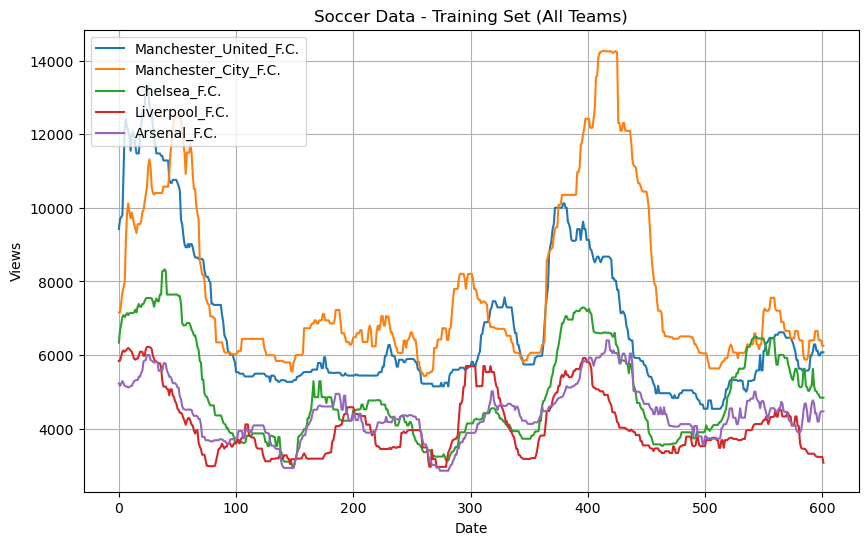

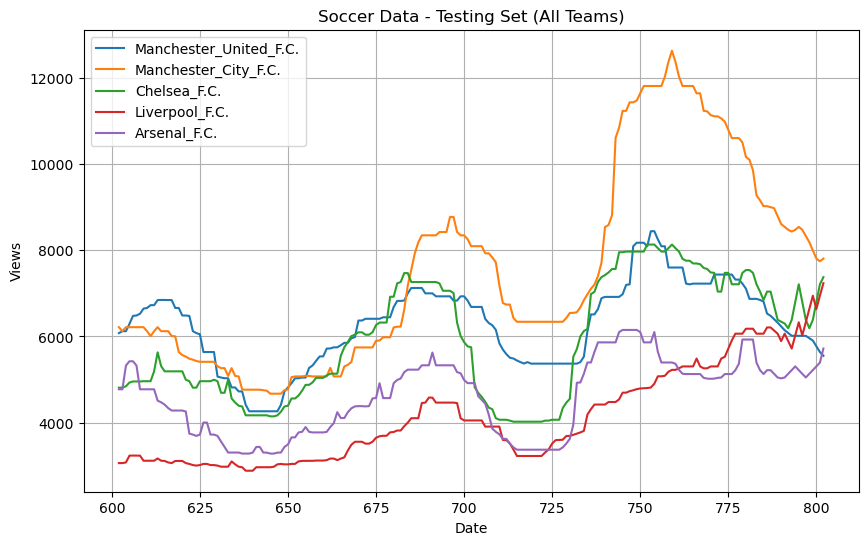

smoothed_test_tech shape: (5, 201)
time_test_tech shape: (201,)


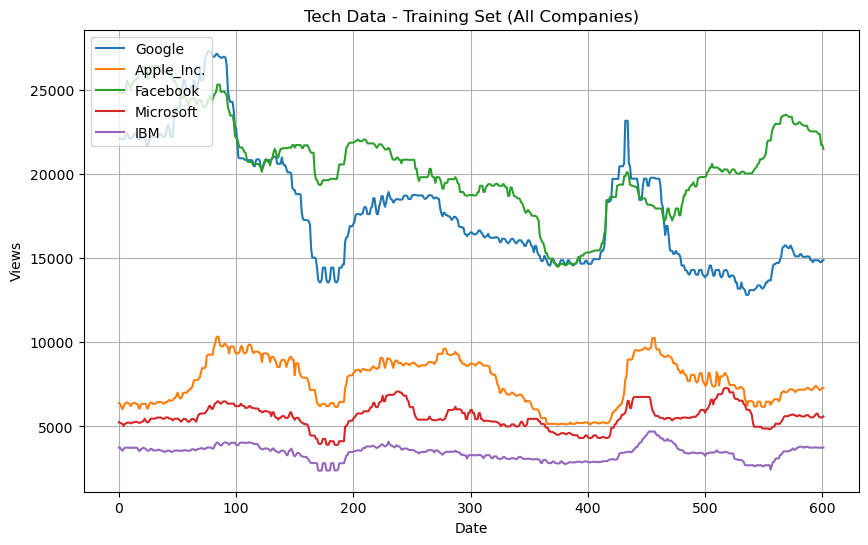

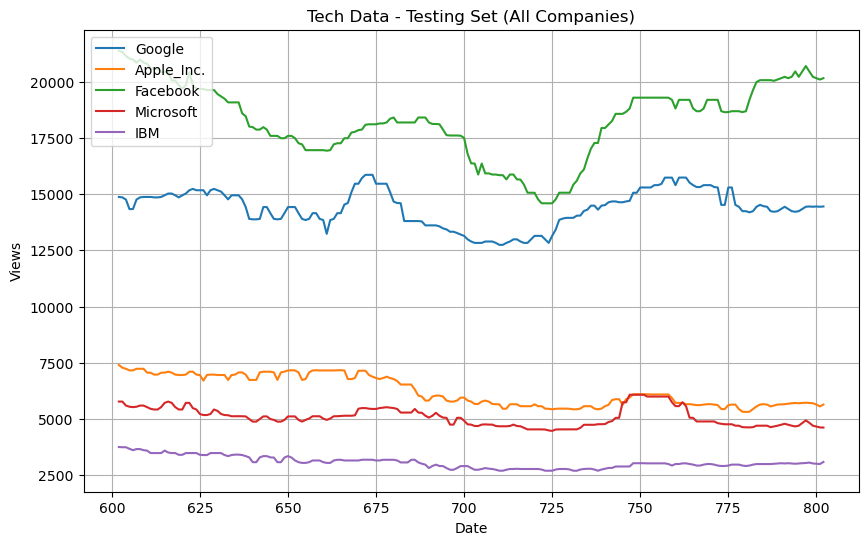

smoothed_test_politics shape: (5, 201)
time_test_politics shape: (201,)


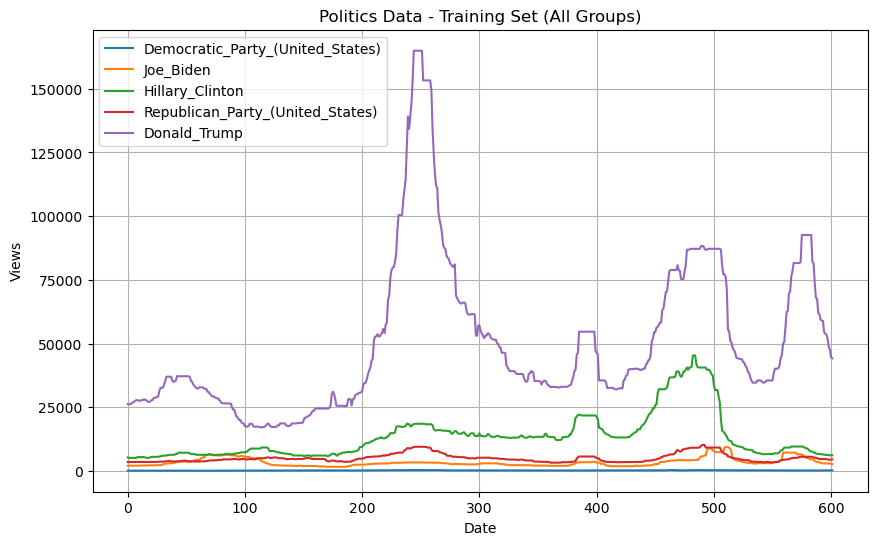

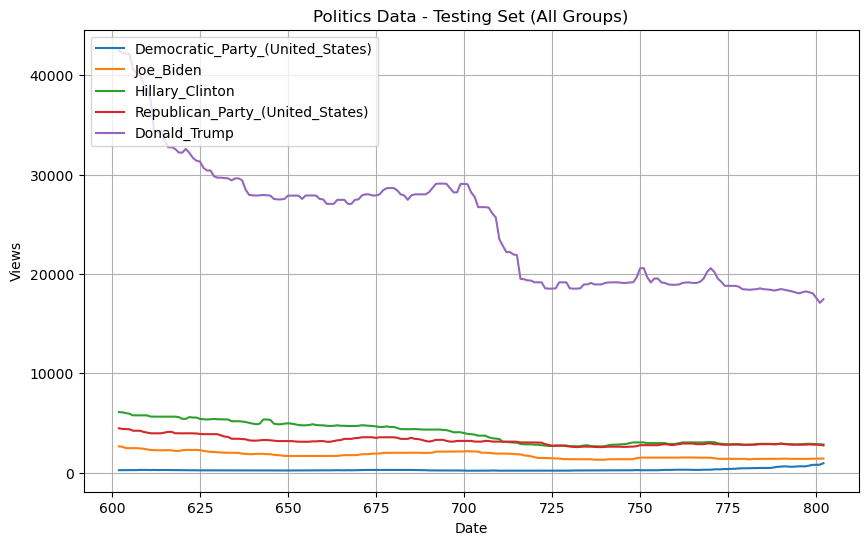

In [2]:
# Load datasets
all_data = load_all()
tech = load_tech()
politics = load_politics()
soccer = load_soccer()

# --- Soccer Data ---
# Extract names and values for soccer data
soccer_names, soccer_values = extract_names_and_values(soccer)

# Add feature names for soccer
soccer_feature_names = ["time_step"] + soccer_names
# Apply smoothing to soccer data
smoothed_soccer = smooth_data(soccer_values)

# Split smoothed soccer data into training and testing sets
X_train_soccer, X_test_soccer, y_train_soccer, y_test_soccer = split_train_test_matrix(
    smoothed_soccer, train_ratio=0.75, target_column=0, smoothed=True  # Use smoothed=True for smoothed data
)

# Generate integer day labels
time_train_soccer = np.arange(X_train_soccer.shape[0])  # Days for training set
time_test_soccer = np.arange(X_train_soccer.shape[0], X_train_soccer.shape[0] + X_test_soccer.shape[0])

# Adjust `time_test_soccer` to match the number of test columns
smoothed_test_soccer = smoothed_soccer[:, X_train_soccer.shape[0]:]  # Extract test data
time_test_soccer = time_test_soccer[:smoothed_test_soccer.shape[1]]  # Ensure time axis matches test data

# Debugging shapes
print("smoothed_soccer shape:", smoothed_soccer.shape)
print("time_train_soccer shape:", time_train_soccer.shape)
print("time_test_soccer shape:", time_test_soccer.shape)
print("smoothed_test_soccer shape:", smoothed_test_soccer.shape)

# Plot all soccer teams in the training set
plot_group(
    names=soccer_feature_names[1:],  # Exclude "time_step"
    smoothed_values=smoothed_soccer[:, :X_train_soccer.shape[0]],  # Training set of smoothed data
    dates=time_train_soccer,
    title="Soccer Data - Training Set (All Teams)"
)

# Plot all soccer teams in the testing set
plot_group(
    names=soccer_feature_names[1:],  # Exclude "time_step"
    smoothed_values=smoothed_test_soccer,  # Testing set of smoothed data
    dates=time_test_soccer,
    title="Soccer Data - Testing Set (All Teams)"
)

# --- Tech Data ---
# Extract names and values for tech data
tech_names, tech_values = extract_names_and_values(tech)

# Add feature names for tech
tech_feature_names = ["time_step"] + tech_names

# Apply smoothing to tech data
smoothed_tech = smooth_data(tech_values)

# Split Tech data into training and testing sets
X_train_tech, X_test_tech, y_train_tech, y_test_tech = split_train_test_matrix(
    smoothed_tech, train_ratio=0.75, target_column=0, smoothed=True  # Use smoothed=True for smoothed data
)

# Generate integer day labels for Tech
time_train_tech = np.arange(X_train_tech.shape[0])
time_test_tech = np.arange(X_train_tech.shape[0], X_train_tech.shape[0] + X_test_tech.shape[0])

# Adjust slicing for smoothed test data
smoothed_test_tech = smoothed_tech[:, X_train_tech.shape[0]:]
time_test_tech = time_test_tech[:smoothed_test_tech.shape[1]]  # Ensure time axis matches smoothed_values

# Debugging shapes
print("smoothed_test_tech shape:", smoothed_test_tech.shape)
print("time_test_tech shape:", time_test_tech.shape)

# Plot all tech companies in the training set
plot_group(
    names=tech_feature_names[1:],  # Exclude "time_step"
    smoothed_values=smoothed_tech[:, :X_train_tech.shape[0]],
    dates=time_train_tech,
    title="Tech Data - Training Set (All Companies)"
)

# Plot all tech companies in the testing set
plot_group(
    names=tech_feature_names[1:],  # Exclude "time_step"
    smoothed_values=smoothed_test_tech,
    dates=time_test_tech,
    title="Tech Data - Testing Set (All Companies)"
)
# --- Politics Data ---
# Extract names and values for politics data
politics_names, politics_values = extract_names_and_values(politics)

# Add feature names for politics
politics_feature_names = ["time_step"] + politics_names

# Apply smoothing to politics data
smoothed_politics = smooth_data(politics_values)

# Split Politics data into training and testing sets
X_train_politics, X_test_politics, y_train_politics, y_test_politics = split_train_test_matrix(
    smoothed_politics, train_ratio=0.75, target_column=0, smoothed=True  # Use smoothed=True for smoothed data
)

# Generate integer day labels for Politics
time_train_politics = np.arange(X_train_politics.shape[0])
time_test_politics = np.arange(X_train_politics.shape[0], X_train_politics.shape[0] + X_test_politics.shape[0])

# Adjust slicing for smoothed test data
smoothed_test_politics = smoothed_politics[:, X_train_politics.shape[0]:]
time_test_politics = time_test_politics[:smoothed_test_politics.shape[1]]  # Ensure time axis matches smoothed_values

# Debugging shapes
print("smoothed_test_politics shape:", smoothed_test_politics.shape)
print("time_test_politics shape:", time_test_politics.shape)

# Plot all political groups in the training set
plot_group(
    names=politics_feature_names[1:],  # Exclude "time_step"
    smoothed_values=smoothed_politics[:, :X_train_politics.shape[0]],
    dates=time_train_politics,
    title="Politics Data - Training Set (All Groups)"
)

# Plot all political groups in the testing set
plot_group(
    names=politics_feature_names[1:],  # Exclude "time_step"
    smoothed_values=smoothed_test_politics,
    dates=time_test_politics,
    title="Politics Data - Testing Set (All Groups)"
)

# Soccer Data
Test on soccer data with 100 inducing points.

## Parameter Initialization

In [3]:
# Initialize PRNG
init_prng(0)

# Initialize inducing points as a subset of X_train
Z = initialize_inducing_points(X_train_soccer, num_inducing=100)

# Define a function to initialize hyperparameters for the combined kernel
def random_init_combined_hyperparams(X_train):
    # Determine the number of input dimensions from X_train
    dims = X_train.shape[1]
    
    # Three initial weights in log space for unconstrained optimization (converted to float)
    initial_weights = [0, 0, 0, 0, 0]
    
    # Initial hyperparameters for each kernel
    hyperparams_sqexp = [0.1, 1.0, 10.0]        # [noise_variance, signal_variance, length_scale]
    hyperparams_linear = [0.1, 1.0]             # [noise_variance, signal_variance]
    hyperparams_matern = [0.1, 1.0, 10.0]       # [noise_variance, signal_variance, length_scale]
    hyperparams_sinusoidal = [0.1, 1.0, 10.0, 1.0]  # [noise_variance, signal_variance, period, length_scale]

    # Initialize spectral mixture hyperparameters
    num_mixtures = 10
    hyperparams_spectralmixture = [0.1]  # Start with noise_variance and number of mixtures

    for _ in range(num_mixtures):
        weight = 1 / num_mixtures  # Equal weight for each mixture initially
        mean = random.uniform(grab_prng(), shape=(dims,), minval=-5, maxval=5).tolist()
        variance = random.uniform(grab_prng(), shape=(dims,), minval=-5, maxval=5).tolist()
        hyperparams_spectralmixture.append(weight)  # Add weight
        hyperparams_spectralmixture.extend(mean)  # Add flattened mean
        hyperparams_spectralmixture.extend(variance)  # Add flattened variance
    #

    # Concatenate all hyperparameters
    initial_params = (
        initial_weights +
        hyperparams_sqexp +
        hyperparams_linear +
        hyperparams_matern +
        hyperparams_sinusoidal +
        hyperparams_spectralmixture
    )
    
    return np.array(initial_params, dtype=np.float32)
#


# Initialize hyperparameters in the unconstrained space
unconstrained_hyperparams_init = random_init_combined_hyperparams(X_train_soccer)


## Define the Optimization Loop for ELBO

In [4]:
# Set the gradient ascent step size and number of steps
step_size = 1e-7
num_steps = 500

# Optimize ELBO using the empirical Bayes function` `
optimized_hyperparams, final_elbo, history = empirical_bayes(X_train_soccer, y_train_soccer, Z, unconstrained_hyperparams_init, step_size, num_steps)

print("Optimized Hyperparameters:", optimized_hyperparams)
print("Final ELBO Value:", final_elbo)

Step 0, ELBO: -27543869.426907163
Step 10, ELBO: -4084996.9612817355
Step 20, ELBO: -2303523.8421919
Step 30, ELBO: -1610166.2485314684
Step 40, ELBO: -1238369.5958051675
Step 50, ELBO: -1005970.6724350613
Step 60, ELBO: -846804.563853333
Step 70, ELBO: -730931.3462545691
Step 80, ELBO: -642797.6968926789
Step 90, ELBO: -573511.7708006138
Step 100, ELBO: -517618.49503879127
Step 110, ELBO: -471583.2679639024
Step 120, ELBO: -433014.5135001025
Step 130, ELBO: -400236.88238690817
Step 140, ELBO: -372040.49554682546
Step 150, ELBO: -347530.98284144147
Step 160, ELBO: -326031.8042599497
Step 170, ELBO: -307022.7898429846
Step 180, ELBO: -290096.14233590855
Step 190, ELBO: -274929.5158099498
Step 200, ELBO: -261262.49609217676
Step 210, ELBO: -248884.14656026987
Step 220, ELBO: -237621.49379360612
Step 230, ELBO: -227330.8661039582
Step 240, ELBO: -217891.8766334193
Step 250, ELBO: -209203.80578243654
Step 260, ELBO: -201180.79271563713
Step 270, ELBO: -193749.6642692268
Step 280, ELBO: -18

In [16]:
# Total noise variance
total_noise = np.sum(np.array([optimized_hyperparams[i] for i in [5, 8, 10, 13, 17]]))
print("\nTotal noise:", total_noise)


Total noise: 1705.5667


## Predict and Plot the Results

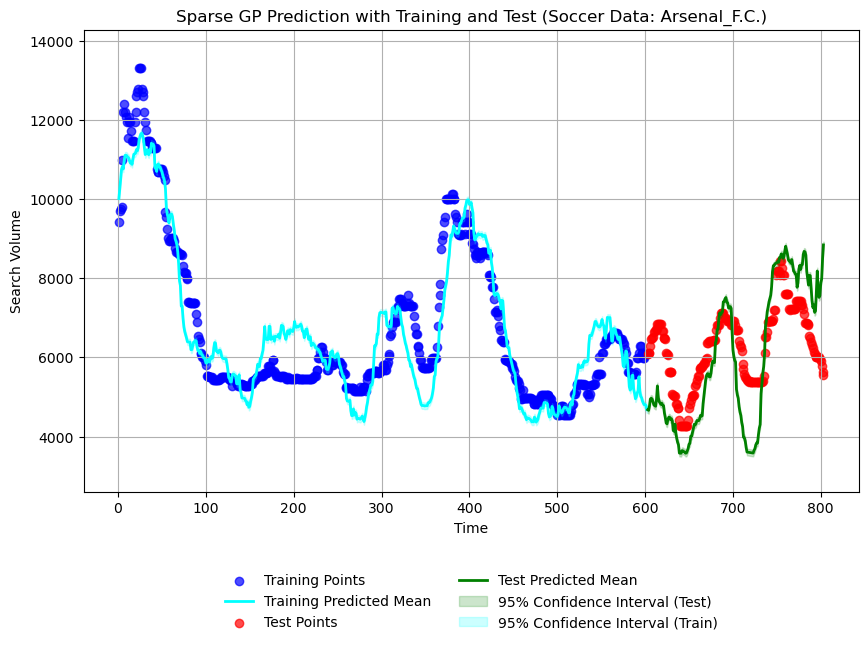

In [17]:
plot_sparse_gp_with_uncertainty_clean(
    X_train_soccer, 
    y_train_soccer, 
    X_test_soccer, 
    y_test_soccer, 
    Z, 
    optimized_hyperparams, 
    sparse_gp_posterior_predictive, 
    title_suffix=f" (Soccer Data: {soccer_feature_names[-1]})"
)

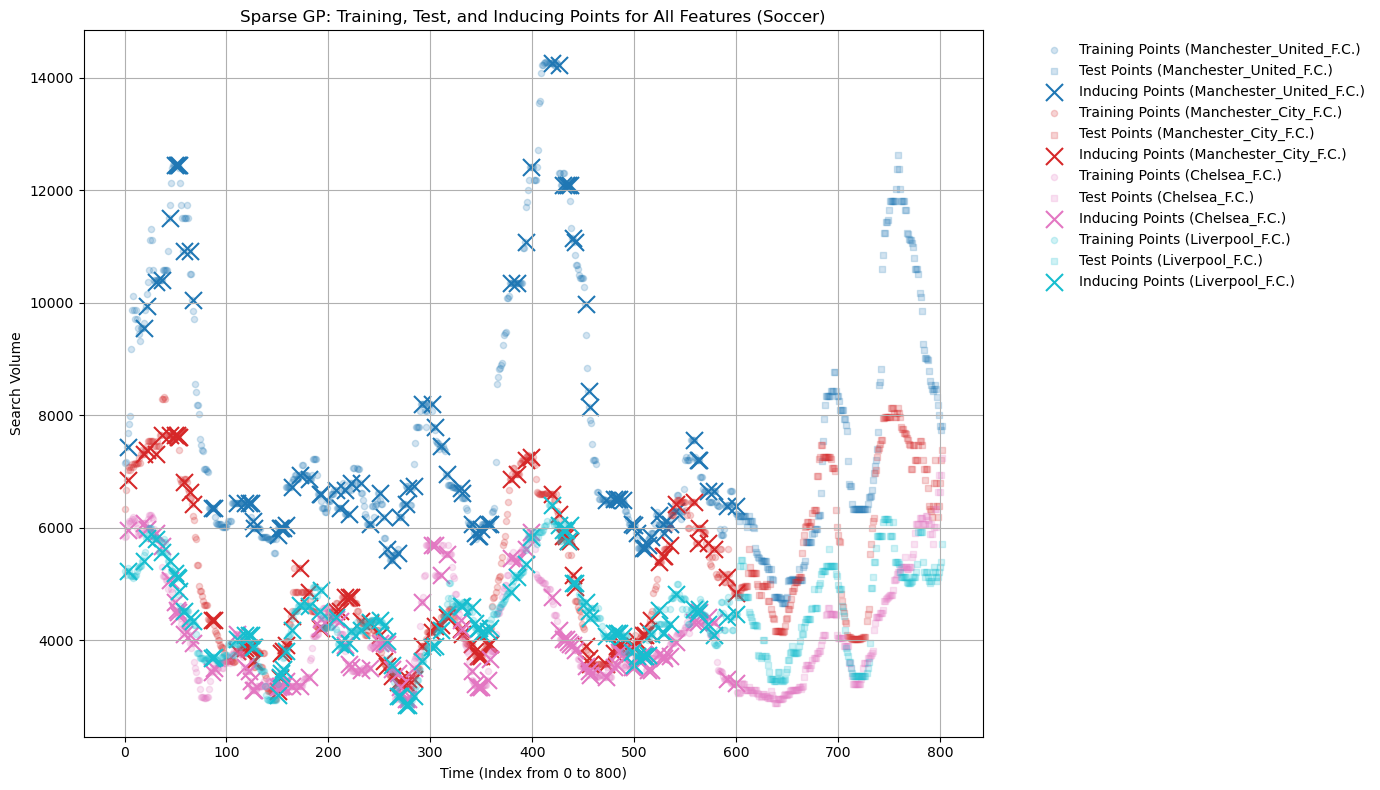

In [7]:
plot_sparse_gp_with_uncertainty_inducing(
    X_train_soccer, y_train_soccer, X_test_soccer, y_test_soccer, Z, optimized_hyperparams, sparse_gp_posterior_predictive, title_suffix=" (Soccer)", feature_names=soccer_feature_names
)

In [8]:
# Extract weights
weights = optimized_hyperparams[:5]
weight_percentages = (weights / np.sum(weights)) * 100

# Print the weights
print("Kernel Weights:")
print(f"Kernel 1 (Squared-Exponential): {weights[0]:.4f}")
print(f"Kernel 2 (Linear): {weights[1]:.4f}")
print(f"Kernel 3 (Matérn): {weights[2]:.4f}")
print(f"Kernel 4 (Sinusoidal): {optimized_hyperparams[3]:.4f}")
print(f"Kernel 5 (Spectral Mixture): {optimized_hyperparams[4]:.4f}")

# Print weights as percentages for each kernel
print("\nKernel Weights as Percentages:")
print(f"Kernel 1 (Squared-Exponential): {weight_percentages[0]:.2f}%")
print(f"Kernel 2 (Linear): {weight_percentages[1]:.2f}%")
print(f"Kernel 3 (Matérn): {weight_percentages[2]:.2f}%")
print(f"Kernel 4 (Sinusoidal): {weight_percentages[3]:.2f}%")
print(f"Kernel 5 (Spectral Mixture): {weight_percentages[4]:.2f}%")

# Print other hyperparameters for each kernel
print("\nOther Hyperparameters:")
print(f"Kernel 1 - Noise Variance: {optimized_hyperparams[5]:.4f}")
print(f"Kernel 1 - Signal Variance: {optimized_hyperparams[6]:.4f}")
print(f"Kernel 1 - Length Scale: {optimized_hyperparams[7]:.4f}")
print(f"Kernel 2 - Noise Variance: {optimized_hyperparams[8]:.4f}")
print(f"Kernel 2 - Signal Variance: {optimized_hyperparams[9]:.4f}")
print(f"Kernel 3 - Noise Variance: {optimized_hyperparams[10]:.4f}")
print(f"Kernel 3 - Signal Variance: {optimized_hyperparams[11]:.4f}")
print(f"Kernel 3 - Length Scale: {optimized_hyperparams[12]:.4f}")
print(f"Kernel 4 - Noise Variance: {optimized_hyperparams[13]:.4f}")
print(f"Kernel 4 - Signal Variance: {optimized_hyperparams[14]:.4f}")
print(f"Kernel 4 - Period: {optimized_hyperparams[15]:.4f}")
print(f"Kernel 4 - Length Scale: {optimized_hyperparams[16]:.4f}")
print(f"Kernel 5 - Noise Variance: {optimized_hyperparams[17]:.4f}")

# Print rest of the hyperparameters for the spectral mixture kernel
dim = X_train_soccer.shape[1]
i = 18
mixture_count = 1
while i < len(optimized_hyperparams):
    print(f"\nSpectral Mixture Kernel - Mixture {mixture_count}:")
    print(f"Weight: {optimized_hyperparams[i: i + 1][0]:.4f}")
    print(f"Means: {optimized_hyperparams[i + 1: i + 1 + dim]}")
    print(f"Variances: {optimized_hyperparams[i + 1 + dim: i + 1 + 2 * dim]}")
    i += 1 + 2 * dim
    mixture_count += 1
#

Kernel Weights:
Kernel 1 (Squared-Exponential): 1.5378
Kernel 2 (Linear): 1.0001
Kernel 3 (Matérn): 1.0506
Kernel 4 (Sinusoidal): 1.0257
Kernel 5 (Spectral Mixture): 1.4638

Kernel Weights as Percentages:
Kernel 1 (Squared-Exponential): 25.30%
Kernel 2 (Linear): 16.45%
Kernel 3 (Matérn): 17.29%
Kernel 4 (Sinusoidal): 16.88%
Kernel 5 (Spectral Mixture): 24.08%

Other Hyperparameters:
Kernel 1 - Noise Variance: 341.1133
Kernel 1 - Signal Variance: 4.1801
Kernel 1 - Length Scale: 28808.8633
Kernel 2 - Noise Variance: 341.1133
Kernel 2 - Signal Variance: 2.7184
Kernel 3 - Noise Variance: 341.1133
Kernel 3 - Signal Variance: 2.8559
Kernel 3 - Length Scale: 20983.1328
Kernel 4 - Noise Variance: 341.1133
Kernel 4 - Signal Variance: 2.7882
Kernel 4 - Period: 22026.4648
Kernel 4 - Length Scale: 2.7183
Kernel 5 - Noise Variance: 341.1133

Spectral Mixture Kernel - Mixture 1:
Weight: 1.1123
Means: [0.22110732 0.8402123  0.00827456 1.3827755  3.7727633 ]
Variances: [1.99655495e+01 4.03186646e+01 1

## NLPD

In [9]:
train_nlpd = calculate_nlpd(X_train_soccer, y_train_soccer, Z, optimized_hyperparams, sparse_gp_posterior_predictive, X_train_soccer, y_train_soccer)
test_nlpd = calculate_nlpd(X_test_soccer, y_test_soccer, Z, optimized_hyperparams, sparse_gp_posterior_predictive, X_train_soccer, y_train_soccer)

print(f"Train NLPD: {train_nlpd:.4f}")
print(f"Test NLPD: {test_nlpd:.4f}")

Train NLPD: 87.3740
Test NLPD: 212.1806


## MSE

In [10]:
Y_pred, _ = sparse_gp_posterior_predictive(X_test_soccer, X_train_soccer, y_train_soccer, Z, optimized_hyperparams)
mse = calculate_mse(y_test_soccer, Y_pred) 
print(f"MSE: {mse:.4f}")

MSE: 1464893.1680


## ELBO Maximization

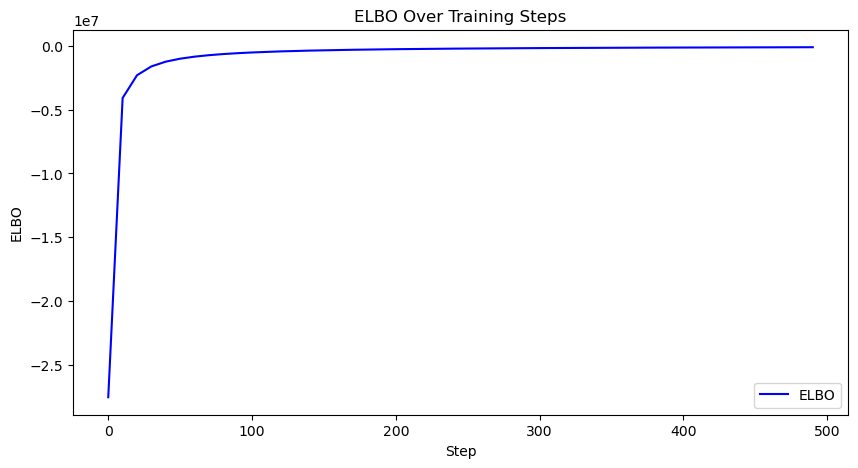

In [11]:
plot_elbo(history)

## Kernel Hyperparameters

Unchanged Hyperparameters:
 - Length Scale (Sinusoidal)
 - Period (Sinusoidal)
 - SM Variance 1, Dim 5
 - SM Weight 2
 - SM Mean 2, Dim 1
 - SM Variance 2, Dim 1
 - SM Mean 2, Dim 2
 - SM Variance 2, Dim 2
 - SM Mean 2, Dim 3
 - SM Variance 2, Dim 3
 - SM Mean 2, Dim 4
 - SM Variance 2, Dim 4
 - SM Mean 2, Dim 5
 - SM Variance 2, Dim 5
 - SM Weight 3
 - SM Mean 3, Dim 1
 - SM Variance 3, Dim 1
 - SM Mean 3, Dim 2
 - SM Variance 3, Dim 2
 - SM Mean 3, Dim 3
 - SM Variance 3, Dim 3
 - SM Mean 3, Dim 4
 - SM Variance 3, Dim 4
 - SM Mean 3, Dim 5
 - SM Variance 3, Dim 5
 - SM Weight 4
 - SM Mean 4, Dim 1
 - SM Variance 4, Dim 1
 - SM Mean 4, Dim 2
 - SM Variance 4, Dim 2
 - SM Mean 4, Dim 3
 - SM Variance 4, Dim 3
 - SM Mean 4, Dim 4
 - SM Variance 4, Dim 4
 - SM Mean 4, Dim 5
 - SM Variance 4, Dim 5
 - SM Weight 5
 - SM Mean 5, Dim 1
 - SM Variance 5, Dim 1
 - SM Mean 5, Dim 2
 - SM Variance 5, Dim 2
 - SM Mean 5, Dim 3
 - SM Variance 5, Dim 3
 - SM Mean 5, Dim 4
 - SM Variance 5, Dim 4
 

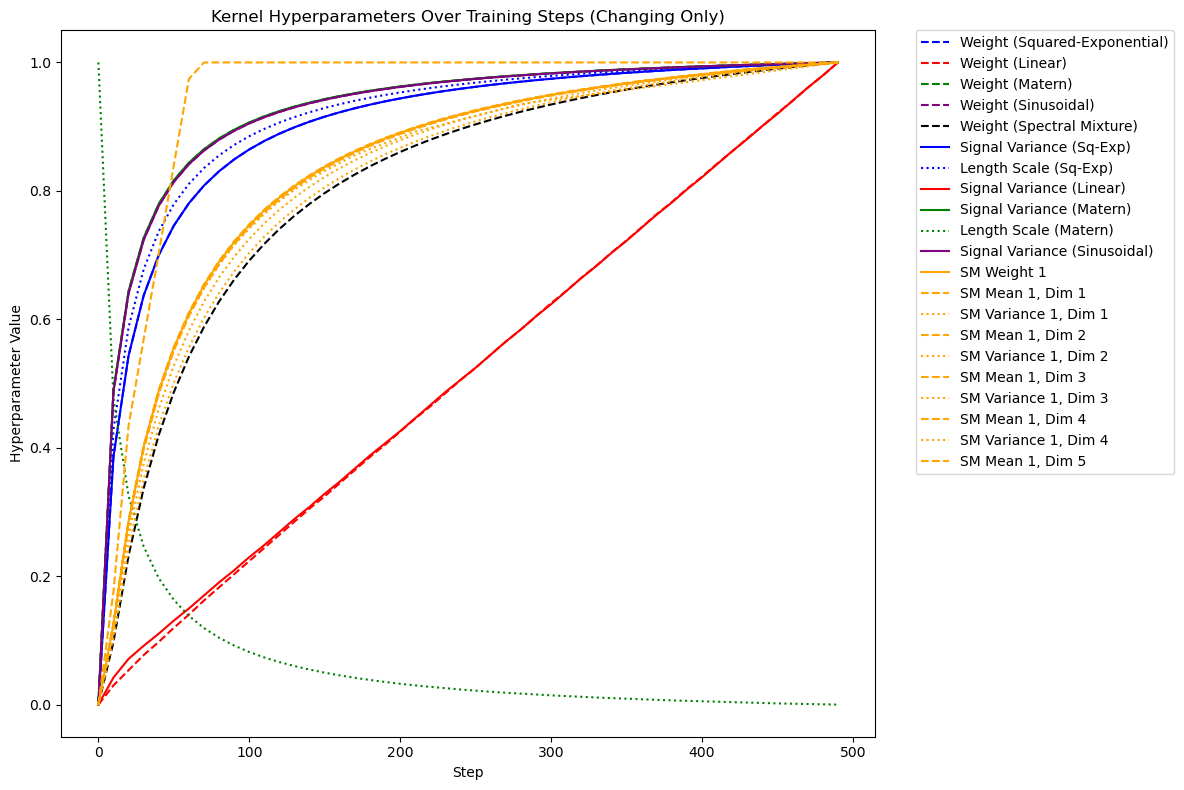

In [12]:
plot_kernel_hyperparameters(history, dims=5)

## Political Data

In [19]:


# Define a function to initialize hyperparameters for the combined kernel
def random_init_combined_hyperparams(X_train):
    # Determine the number of input dimensions from X_train
    dims = X_train.shape[1]
    
    # Three initial weights in log space for unconstrained optimization (converted to float)
    initial_weights = [0, 0, 0, 0, 0]
    
    # Initial hyperparameters for each kernel
    hyperparams_sqexp = [2, 1.0, 30.0]        # [noise_variance, signal_variance, length_scale]
    hyperparams_linear = [2, 1.0]             # [noise_variance, signal_variance]
    hyperparams_matern = [2, 1.0, 30.0]       # [noise_variance, signal_variance, length_scale]
    hyperparams_sinusoidal = [2, 1.0, 20.0, 15.0]  # [noise_variance, signal_variance, period, length_scale]

    # Initialize spectral mixture hyperparameters
    num_mixtures = 10
    hyperparams_spectralmixture = [3]  # Start with noise_variance and number of mixtures

    for _ in range(num_mixtures):
        weight = 1 / num_mixtures  # Equal weight for each mixture initially
        mean = random.uniform(grab_prng(), shape=(dims,), minval=-5, maxval=5).tolist()
        variance = random.uniform(grab_prng(), shape=(dims,), minval=-5, maxval=5).tolist()
        hyperparams_spectralmixture.append(weight)  # Add weight
        hyperparams_spectralmixture.extend(mean)  # Add flattened mean
        hyperparams_spectralmixture.extend(variance)  # Add flattened variance
    #

    # Concatenate all hyperparameters
    initial_params = (
        initial_weights +
        hyperparams_sqexp +
        hyperparams_linear +
        hyperparams_matern +
        hyperparams_sinusoidal +
        hyperparams_spectralmixture
    )
    
    return np.array(initial_params, dtype=np.float32)

In [20]:
grab_prng()
#init inducing points + unconstrained HPs
Z= initialize_inducing_points(X_train_politics,100)
unconstrained_hyperparams_init = random_init_combined_hyperparams(X_train_politics)


In [21]:
# Set the gradient ascent step size and number of steps
step_size = 1e-6
num_steps = 500

# Optimize ELBO using the empirical Bayes function
optimized_hyperparams, final_elbo, history = empirical_bayes(X_train_politics, y_train_politics, Z, unconstrained_hyperparams_init, step_size, num_steps)

print("Optimized Hyperparameters:", optimized_hyperparams)
print("Final ELBO Value:", final_elbo)

Step 0, ELBO: -6274.002294063086
Step 10, ELBO: -6218.631091565516
Step 20, ELBO: -6164.255811122428
Step 30, ELBO: -6110.841439190419
Step 40, ELBO: -6058.361111420014
Step 50, ELBO: -6006.787506065859
Step 60, ELBO: -5956.09559940736
Step 70, ELBO: -5906.255488643881
Step 80, ELBO: -5857.248726866237
Step 90, ELBO: -5809.051506760847
Step 100, ELBO: -5761.645405128306
Step 110, ELBO: -5715.00187960399
Step 120, ELBO: -5669.099556477724
Step 130, ELBO: -5623.929365766692
Step 140, ELBO: -5579.463244271186
Step 150, ELBO: -5535.689546228574
Step 160, ELBO: -5492.579985064053
Step 170, ELBO: -5450.127313110927
Step 180, ELBO: -5408.316949678708
Step 190, ELBO: -5367.127995773266
Step 200, ELBO: -5326.5480677497335
Step 210, ELBO: -5286.562582072953
Step 220, ELBO: -5247.153174826478
Step 230, ELBO: -5208.314154224013
Step 240, ELBO: -5170.027792123728
Step 250, ELBO: -5132.285219441227
Step 260, ELBO: -5095.070767343153
Step 270, ELBO: -5058.374483674286
Step 280, ELBO: -5022.1908125790

In [22]:
# Total noise variance
total_noise = np.sum(np.array([optimized_hyperparams[i] for i in [5, 8, 10, 13, 17]]))
print("\nTotal noise:", total_noise)


Total noise: 84.38992


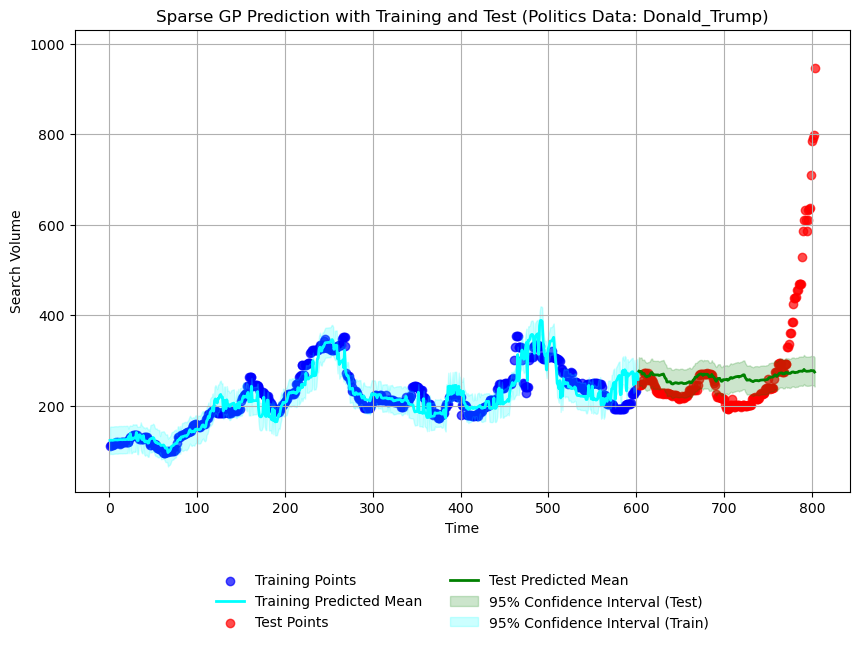

In [23]:
plot_sparse_gp_with_uncertainty_clean(
    X_train_politics, 
    y_train_politics, 
    X_test_politics, 
    y_test_politics, 
    Z, 
    optimized_hyperparams, 
    sparse_gp_posterior_predictive, 
    title_suffix=f" (Politics Data: {politics_feature_names[-1]})"
)

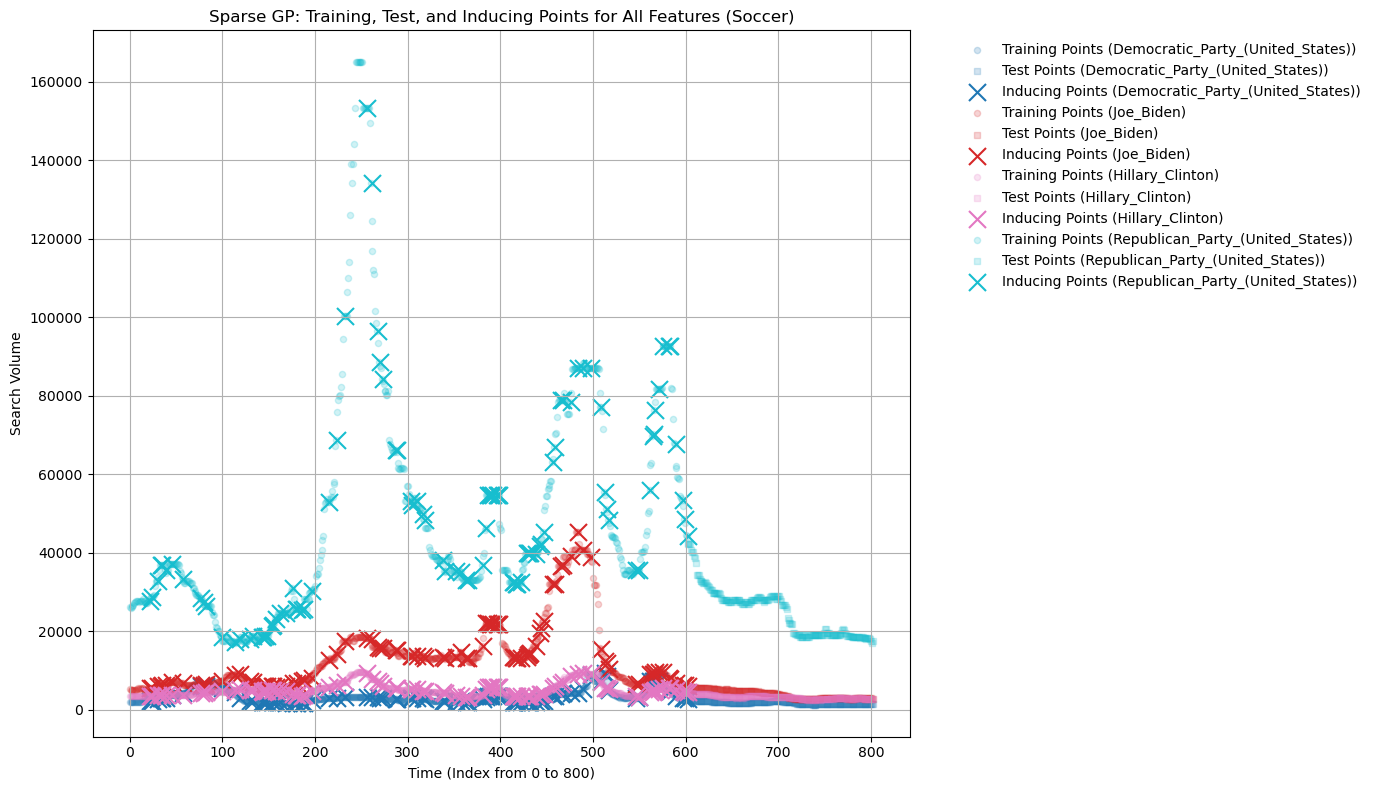

In [24]:
plot_sparse_gp_with_uncertainty_inducing(
    X_train_politics, y_train_politics, X_test_politics, y_test_politics, Z, optimized_hyperparams, sparse_gp_posterior_predictive, title_suffix=" (Politics)", feature_names=politics_feature_names
)

In [25]:
# Extract weights
weights = optimized_hyperparams[:5]
weight_percentages = (weights / np.sum(weights)) * 100

# Print the weights
print("Kernel Weights:")
print(f"Kernel 1 (Squared-Exponential): {weights[0]:.4f}")
print(f"Kernel 2 (Linear): {weights[1]:.4f}")
print(f"Kernel 3 (Matérn): {weights[2]:.4f}")
print(f"Kernel 4 (Sinusoidal): {optimized_hyperparams[3]:.4f}")
print(f"Kernel 5 (Spectral Mixture): {optimized_hyperparams[4]:.4f}")

# Print weights as percentages for each kernel
print("\nKernel Weights as Percentages:")
print(f"Kernel 1 (Squared-Exponential): {weight_percentages[0]:.2f}%")
print(f"Kernel 2 (Linear): {weight_percentages[1]:.2f}%")
print(f"Kernel 3 (Matérn): {weight_percentages[2]:.2f}%")
print(f"Kernel 4 (Sinusoidal): {weight_percentages[3]:.2f}%")
print(f"Kernel 5 (Spectral Mixture): {weight_percentages[4]:.2f}%")

# Print other hyperparameters for each kernel
print("\nOther Hyperparameters:")
print(f"Kernel 1 - Noise Variance: {optimized_hyperparams[5]:.4f}")
print(f"Kernel 1 - Signal Variance: {optimized_hyperparams[6]:.4f}")
print(f"Kernel 1 - Length Scale: {optimized_hyperparams[7]:.4f}")
print(f"Kernel 2 - Noise Variance: {optimized_hyperparams[8]:.4f}")
print(f"Kernel 2 - Signal Variance: {optimized_hyperparams[9]:.4f}")
print(f"Kernel 3 - Noise Variance: {optimized_hyperparams[10]:.4f}")
print(f"Kernel 3 - Signal Variance: {optimized_hyperparams[11]:.4f}")
print(f"Kernel 3 - Length Scale: {optimized_hyperparams[12]:.4f}")
print(f"Kernel 4 - Noise Variance: {optimized_hyperparams[13]:.4f}")
print(f"Kernel 4 - Signal Variance: {optimized_hyperparams[14]:.4f}")
print(f"Kernel 4 - Period: {optimized_hyperparams[15]:.4f}")
print(f"Kernel 4 - Length Scale: {optimized_hyperparams[16]:.4f}")
print(f"Kernel 5 - Noise Variance: {optimized_hyperparams[17]:.4f}")

# Print rest of the hyperparameters for the spectral mixture kernel
dim = X_train_politics.shape[1]
i = 18
mixture_count = 1
while i < len(optimized_hyperparams):
    print(f"\nSpectral Mixture Kernel - Mixture {mixture_count}:")
    print(f"Weight: {optimized_hyperparams[i: i + 1][0]:.4f}")
    print(f"Means: {optimized_hyperparams[i + 1: i + 1 + dim]}")
    print(f"Variances: {optimized_hyperparams[i + 1 + dim: i + 1 + 2 * dim]}")
    i += 1 + 2 * dim
    mixture_count += 1
#

Kernel Weights:
Kernel 1 (Squared-Exponential): 1.0388
Kernel 2 (Linear): 0.9994
Kernel 3 (Matérn): 1.0388
Kernel 4 (Sinusoidal): 1.0388
Kernel 5 (Spectral Mixture): 0.9946

Kernel Weights as Percentages:
Kernel 1 (Squared-Exponential): 20.33%
Kernel 2 (Linear): 19.56%
Kernel 3 (Matérn): 20.33%
Kernel 4 (Sinusoidal): 20.33%
Kernel 5 (Spectral Mixture): 19.46%

Other Hyperparameters:
Kernel 1 - Noise Variance: 9.3606
Kernel 1 - Signal Variance: 2.8237
Kernel 1 - Length Scale: 10686474223616.0000
Kernel 2 - Noise Variance: 9.3606
Kernel 2 - Signal Variance: 2.7166
Kernel 3 - Noise Variance: 9.3606
Kernel 3 - Signal Variance: 2.8236
Kernel 3 - Length Scale: 10686474223616.0000
Kernel 4 - Noise Variance: 9.3606
Kernel 4 - Signal Variance: 2.8236
Kernel 4 - Period: 485165184.0000
Kernel 4 - Length Scale: 3269017.5000
Kernel 5 - Noise Variance: 46.9476

Spectral Mixture Kernel - Mixture 1:
Weight: 1.1051
Means: [1.1549755e+00 2.0058496e-02 1.4451323e+02 3.9949697e-01 3.2242358e-02]
Variances

In [ ]:
train_nlpd = calculate_nlpd(X_train_politics, y_train_politics, Z, optimized_hyperparams, sparse_gp_posterior_predictive, X_train_politics, y_train_politics)
test_nlpd = calculate_nlpd(X_test_politics, y_test_politics, Z, optimized_hyperparams, sparse_gp_posterior_predictive, X_train_politics, y_train_politics)

print(f"Train NLPD: {train_nlpd:.4f}")
print(f"Test NLPD: {test_nlpd:.4f}")

Train NLPD: 5.7258
Test NLPD: 42.5081


In [ ]:
Y_pred, _ = sparse_gp_posterior_predictive(X_test_politics, X_train_politics, y_train_politics, Z, optimized_hyperparams)
mse = calculate_mse(y_test_politics, Y_pred) 
print(f"MSE: {mse:.4f}")

MSE: 15733.6539


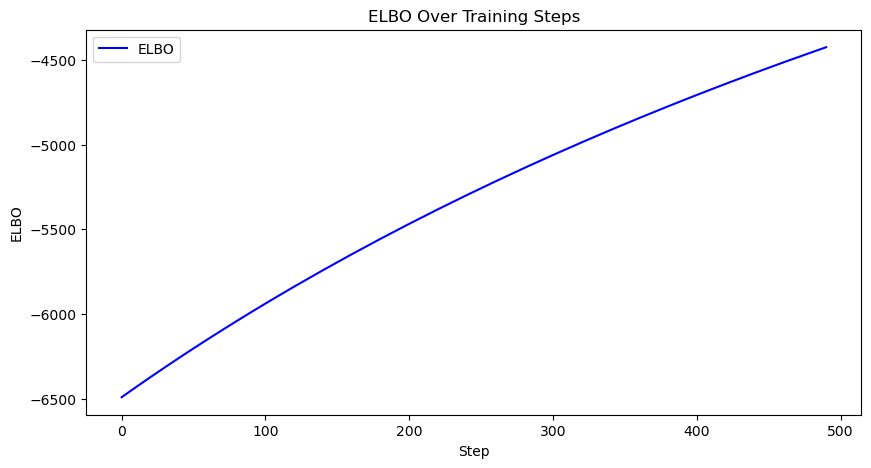

In [ ]:
plot_elbo(history)

Unchanged Hyperparameters:
 - Length Scale (Sq-Exp)
 - Length Scale (Matern)
 - Length Scale (Sinusoidal)
 - Period (Sinusoidal)
 - SM Mean 1, Dim 1
 - SM Variance 1, Dim 1
 - SM Mean 1, Dim 2
 - SM Variance 1, Dim 4
 - SM Variance 1, Dim 5
 - SM Weight 2
 - SM Mean 2, Dim 1
 - SM Variance 2, Dim 1
 - SM Mean 2, Dim 2
 - SM Variance 2, Dim 2
 - SM Mean 2, Dim 3
 - SM Variance 2, Dim 3
 - SM Mean 2, Dim 4
 - SM Variance 2, Dim 4
 - SM Mean 2, Dim 5
 - SM Variance 2, Dim 5
 - SM Weight 3
 - SM Mean 3, Dim 1
 - SM Variance 3, Dim 1
 - SM Mean 3, Dim 2
 - SM Variance 3, Dim 2
 - SM Mean 3, Dim 3
 - SM Variance 3, Dim 3
 - SM Mean 3, Dim 4
 - SM Variance 3, Dim 4
 - SM Mean 3, Dim 5
 - SM Variance 3, Dim 5
 - SM Weight 4
 - SM Mean 4, Dim 1
 - SM Variance 4, Dim 1
 - SM Mean 4, Dim 2
 - SM Variance 4, Dim 2
 - SM Mean 4, Dim 3
 - SM Variance 4, Dim 3
 - SM Mean 4, Dim 4
 - SM Variance 4, Dim 4
 - SM Mean 4, Dim 5
 - SM Variance 4, Dim 5
 - SM Weight 5
 - SM Mean 5, Dim 1
 - SM Variance 5, D

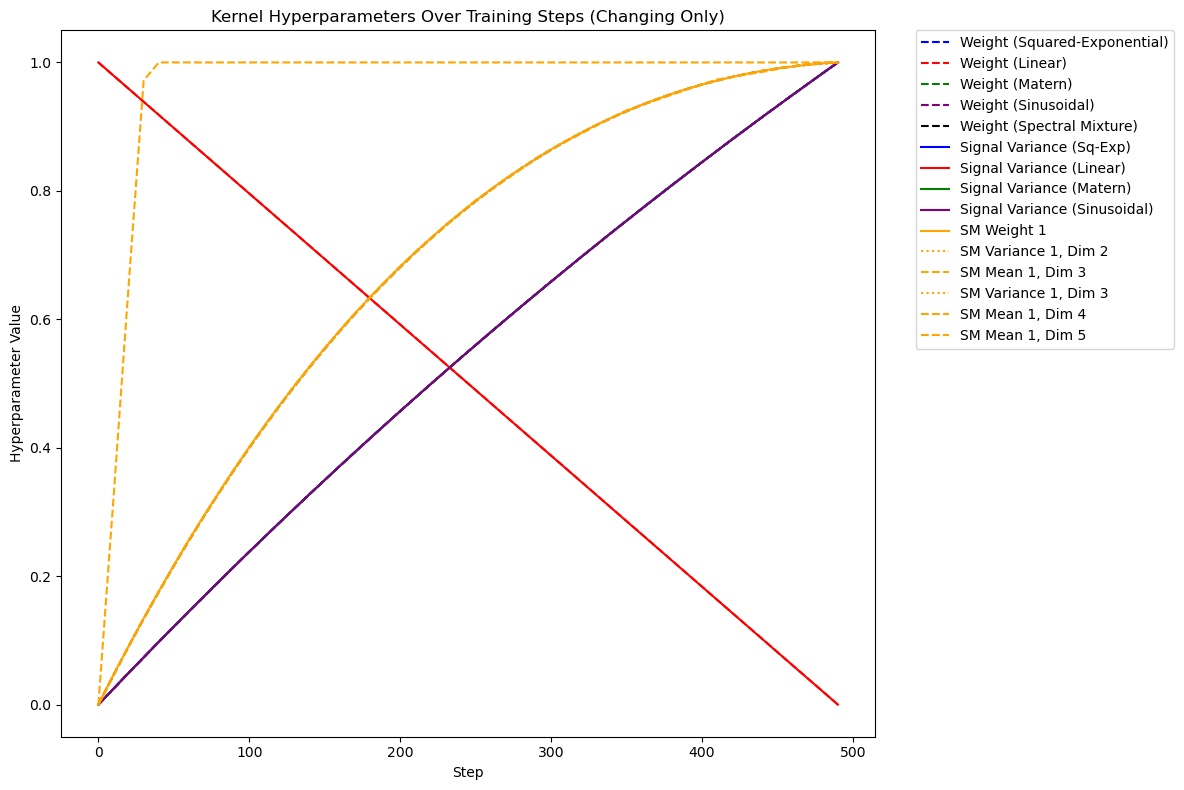

In [ ]:
plot_kernel_hyperparameters(history, dims=5)

## Tech data

In [26]:

# Define a function to initialize hyperparameters for the combined kernel
def random_init_combined_hyperparams323(X_train):
    # Determine the number of input dimensions from X_train
    dims = X_train.shape[1]
    
    # Three initial weights in log space for unconstrained optimization (converted to float)
    initial_weights = [0, 0, 0, 0, 0]
    
    # Initial hyperparameters for each kernel
    hyperparams_sqexp = [0.1, 1.0, 10.0]        # [noise_variance, signal_variance, length_scale]
    hyperparams_linear = [0.1, 1.0]             # [noise_variance, signal_variance]
    hyperparams_matern = [0.1, 1.0, 10.0]       # [noise_variance, signal_variance, length_scale]
    hyperparams_sinusoidal = [0.1, 1.0, 10.0, 1.0]  # [noise_variance, signal_variance, period, length_scale]

    # Initialize spectral mixture hyperparameters
    num_mixtures = 10
    hyperparams_spectralmixture = [0.1]  # Start with noise_variance and number of mixtures

    for _ in range(num_mixtures):
        weight = 1 / num_mixtures  # Equal weight for each mixture initially
        mean = random.uniform(grab_prng(), shape=(dims,), minval=-5, maxval=5).tolist()
        variance = random.uniform(grab_prng(), shape=(dims,), minval=-5, maxval=5).tolist()
        hyperparams_spectralmixture.append(weight)  # Add weight
        hyperparams_spectralmixture.extend(mean)  # Add flattened mean
        hyperparams_spectralmixture.extend(variance)  # Add flattened variance
    #

    # Concatenate all hyperparameters
    initial_params = (
        initial_weights +
        hyperparams_sqexp +
        hyperparams_linear +
        hyperparams_matern +
        hyperparams_sinusoidal +
        hyperparams_spectralmixture
    )
    
    return np.array(initial_params, dtype=np.float32)
#



In [27]:
grab_prng()
#init inducing points + unconstrained HPs
Z= initialize_inducing_points(X_train_tech,100)
unconstrained_hyperparams_init = random_init_combined_hyperparams323(X_train_tech)


In [28]:
# Set the gradient ascent step size and number of steps
step_size = 1e-7
num_steps = 500

# Optimize ELBO using the empirical Bayes function
optimized_hyperparams, final_elbo, history = empirical_bayes(X_train_tech, y_train_tech, Z, unconstrained_hyperparams_init, step_size, num_steps)

print("Optimized Hyperparameters:", optimized_hyperparams)
print("Final ELBO Value:", final_elbo)

Step 0, ELBO: -149155639.49548587
Step 10, ELBO: -3450611.388075551
Step 20, ELBO: -2094443.9746986974
Step 30, ELBO: -1502191.7003676174
Step 40, ELBO: -1169897.1322352432
Step 50, ELBO: -957277.3758152778
Step 60, ELBO: -809626.1583636885
Step 70, ELBO: -701167.8937901249
Step 80, ELBO: -618163.8395405305
Step 90, ELBO: -552618.618752514
Step 100, ELBO: -499565.272106094
Step 110, ELBO: -455754.690078123
Step 120, ELBO: -418973.7684096621
Step 130, ELBO: -387662.07755671034
Step 140, ELBO: -360688.34231632564
Step 150, ELBO: -337213.04272489646
Step 160, ELBO: -316599.7052077898
Step 170, ELBO: -298356.420865303
Step 180, ELBO: -282098.68695231446
Step 190, ELBO: -267520.169910286
Step 200, ELBO: -254374.32453290847
Step 210, ELBO: -242460.6418133702
Step 220, ELBO: -231614.28104771874
Step 230, ELBO: -221698.68927462166
Step 240, ELBO: -212598.96168165084
Step 250, ELBO: -204219.0359279417
Step 260, ELBO: -196477.07623004614
Step 270, ELBO: -189303.0658610001
Step 280, ELBO: -182637

In [29]:
# Total noise variance
total_noise = np.sum(np.array([optimized_hyperparams[i] for i in [5, 8, 10, 13, 17]]))
print("\nTotal noise:", total_noise)


Total noise: 9941.1


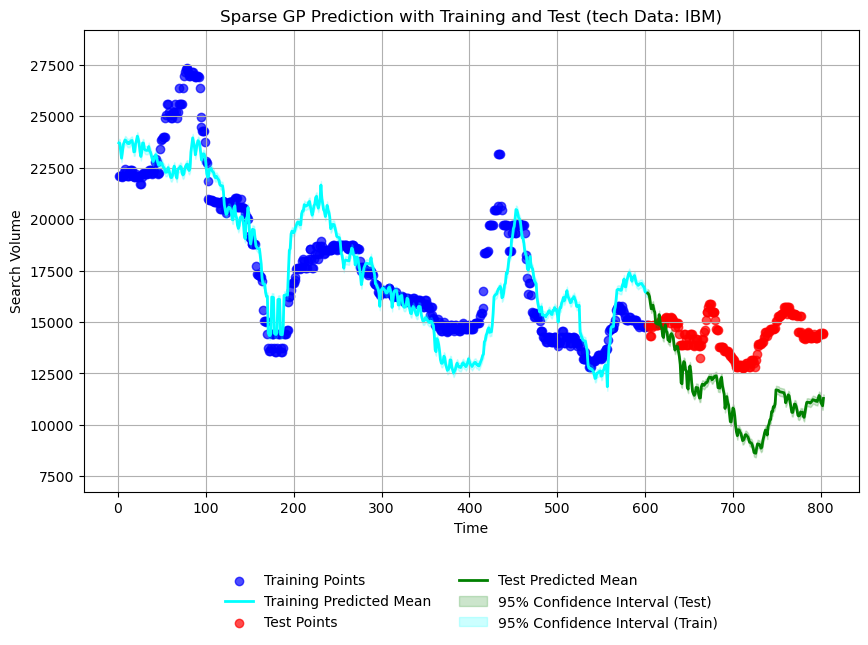

In [30]:
plot_sparse_gp_with_uncertainty_clean(
    X_train_tech, 
    y_train_tech, 
    X_test_tech, 
    y_test_tech, 
    Z, 
    optimized_hyperparams, 
    sparse_gp_posterior_predictive, 
    title_suffix=f" (tech Data: {tech_feature_names[-1]})"
)

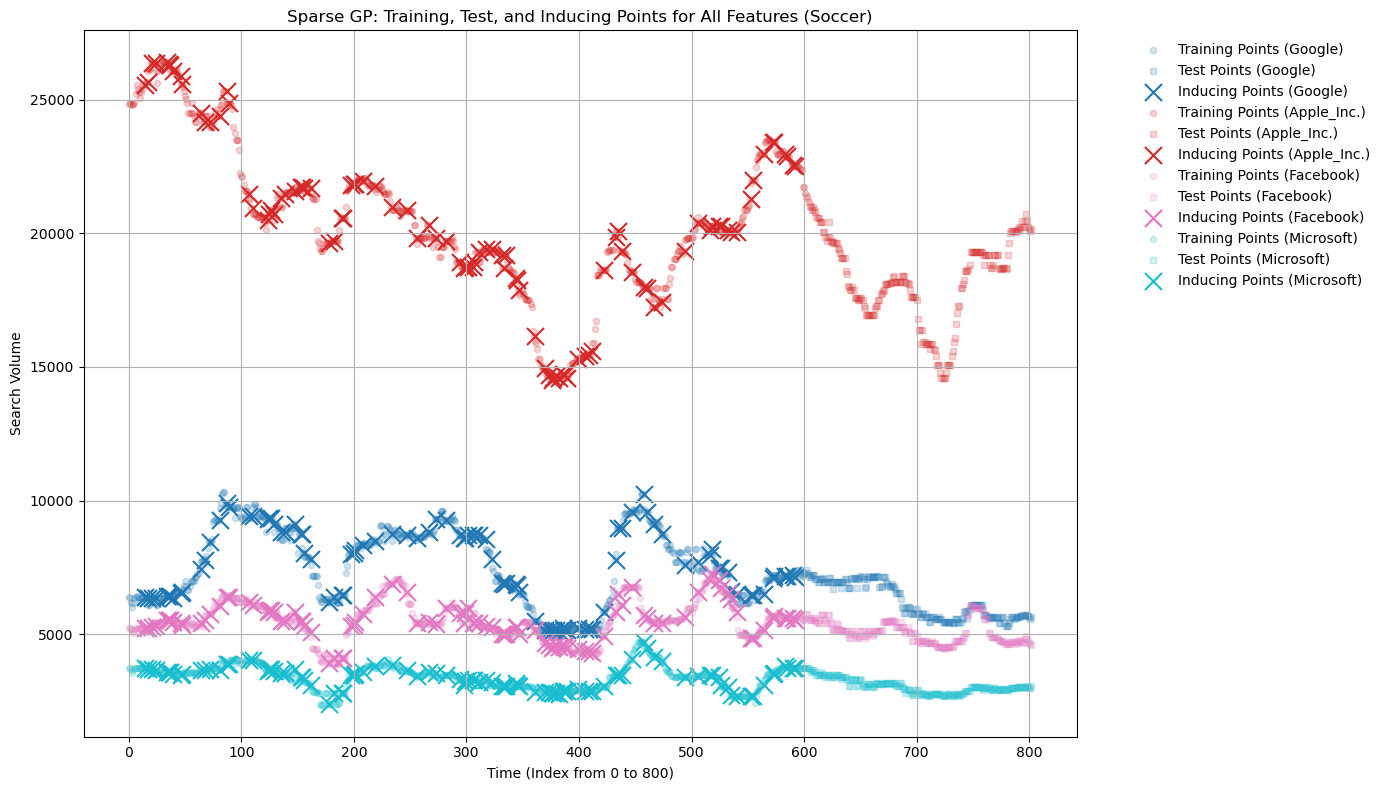

In [31]:
plot_sparse_gp_with_uncertainty_inducing(
    X_train_tech, y_train_tech, X_test_tech, y_test_tech, Z, optimized_hyperparams, sparse_gp_posterior_predictive, title_suffix=" (Tech)", feature_names=tech_feature_names
)

In [32]:
# Extract weights
weights = optimized_hyperparams[:5]
weight_percentages = (weights / np.sum(weights)) * 100

# Print the weights
print("Kernel Weights:")
print(f"Kernel 1 (Squared-Exponential): {weights[0]:.4f}")
print(f"Kernel 2 (Linear): {weights[1]:.4f}")
print(f"Kernel 3 (Matérn): {weights[2]:.4f}")
print(f"Kernel 4 (Sinusoidal): {optimized_hyperparams[3]:.4f}")
print(f"Kernel 5 (Spectral Mixture): {optimized_hyperparams[4]:.4f}")

# Print weights as percentages for each kernel
print("\nKernel Weights as Percentages:")
print(f"Kernel 1 (Squared-Exponential): {weight_percentages[0]:.2f}%")
print(f"Kernel 2 (Linear): {weight_percentages[1]:.2f}%")
print(f"Kernel 3 (Matérn): {weight_percentages[2]:.2f}%")
print(f"Kernel 4 (Sinusoidal): {weight_percentages[3]:.2f}%")
print(f"Kernel 5 (Spectral Mixture): {weight_percentages[4]:.2f}%")

# Print other hyperparameters for each kernel
print("\nOther Hyperparameters:")
print(f"Kernel 1 - Noise Variance: {optimized_hyperparams[5]:.4f}")
print(f"Kernel 1 - Signal Variance: {optimized_hyperparams[6]:.4f}")
print(f"Kernel 1 - Length Scale: {optimized_hyperparams[7]:.4f}")
print(f"Kernel 2 - Noise Variance: {optimized_hyperparams[8]:.4f}")
print(f"Kernel 2 - Signal Variance: {optimized_hyperparams[9]:.4f}")
print(f"Kernel 3 - Noise Variance: {optimized_hyperparams[10]:.4f}")
print(f"Kernel 3 - Signal Variance: {optimized_hyperparams[11]:.4f}")
print(f"Kernel 3 - Length Scale: {optimized_hyperparams[12]:.4f}")
print(f"Kernel 4 - Noise Variance: {optimized_hyperparams[13]:.4f}")
print(f"Kernel 4 - Signal Variance: {optimized_hyperparams[14]:.4f}")
print(f"Kernel 4 - Period: {optimized_hyperparams[15]:.4f}")
print(f"Kernel 4 - Length Scale: {optimized_hyperparams[16]:.4f}")
print(f"Kernel 5 - Noise Variance: {optimized_hyperparams[17]:.4f}")

# Print rest of the hyperparameters for the spectral mixture kernel
dim = X_train_tech.shape[1]
i = 18
mixture_count = 1
while i < len(optimized_hyperparams):
    print(f"\nSpectral Mixture Kernel - Mixture {mixture_count}:")
    print(f"Weight: {optimized_hyperparams[i: i + 1][0]:.4f}")
    print(f"Means: {optimized_hyperparams[i + 1: i + 1 + dim]}")
    print(f"Variances: {optimized_hyperparams[i + 1 + dim: i + 1 + 2 * dim]}")
    i += 1 + 2 * dim
    mixture_count += 1
#

Kernel Weights:
Kernel 1 (Squared-Exponential): 1.3220
Kernel 2 (Linear): 1.0010
Kernel 3 (Matérn): 1.2258
Kernel 4 (Sinusoidal): 1.0550
Kernel 5 (Spectral Mixture): 1.3596

Kernel Weights as Percentages:
Kernel 1 (Squared-Exponential): 22.17%
Kernel 2 (Linear): 16.79%
Kernel 3 (Matérn): 20.56%
Kernel 4 (Sinusoidal): 17.69%
Kernel 5 (Spectral Mixture): 22.80%

Other Hyperparameters:
Kernel 1 - Noise Variance: 1988.2200
Kernel 1 - Signal Variance: 3.5935
Kernel 1 - Length Scale: 25858.4258
Kernel 2 - Noise Variance: 1988.2200
Kernel 2 - Signal Variance: 2.7211
Kernel 3 - Noise Variance: 1988.2200
Kernel 3 - Signal Variance: 3.3320
Kernel 3 - Length Scale: 16768.6328
Kernel 4 - Noise Variance: 1988.2200
Kernel 4 - Signal Variance: 2.8677
Kernel 4 - Period: 22026.4648
Kernel 4 - Length Scale: 2.7183
Kernel 5 - Noise Variance: 1988.2200

Spectral Mixture Kernel - Mixture 1:
Weight: 1.1075
Means: [3.2996078e+01 1.7496657e-01 1.3950937e+00 2.0937737e-02 2.8550288e-01]
Variances: [1.1662188e+

In [ ]:
train_nlpd = calculate_nlpd(X_train_tech, y_train_tech, Z, optimized_hyperparams, sparse_gp_posterior_predictive, X_train_tech, y_train_tech)
test_nlpd = calculate_nlpd(X_test_tech, y_test_tech, Z, optimized_hyperparams, sparse_gp_posterior_predictive, X_train_tech, y_train_tech)

print(f"Train NLPD: {train_nlpd:.4f}")
print(f"Test NLPD: {test_nlpd:.4f}")

Train NLPD: 88.6141
Test NLPD: 252.1048


In [ ]:
Y_pred, _ = sparse_gp_posterior_predictive(X_test_tech, X_train_tech, y_train_tech, Z, optimized_hyperparams)
mse = calculate_mse(y_test_tech, Y_pred) 
print(f"MSE: {mse:.4f}")

MSE: 9914455.1806


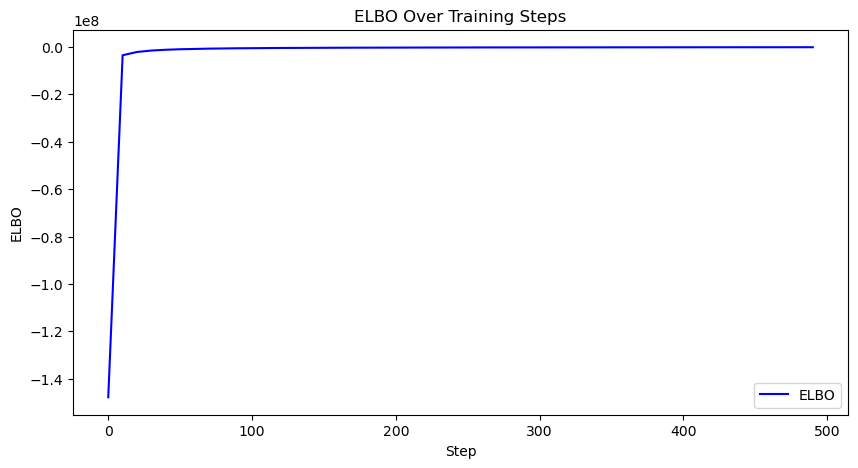

In [ ]:
plot_elbo(history)

Unchanged Hyperparameters:
 - Length Scale (Sinusoidal)
 - SM Variance 1, Dim 5
 - SM Weight 2
 - SM Mean 2, Dim 1
 - SM Variance 2, Dim 1
 - SM Mean 2, Dim 2
 - SM Variance 2, Dim 2
 - SM Mean 2, Dim 3
 - SM Variance 2, Dim 3
 - SM Mean 2, Dim 4
 - SM Variance 2, Dim 4
 - SM Mean 2, Dim 5
 - SM Variance 2, Dim 5
 - SM Weight 3
 - SM Mean 3, Dim 1
 - SM Variance 3, Dim 1
 - SM Mean 3, Dim 2
 - SM Variance 3, Dim 2
 - SM Mean 3, Dim 3
 - SM Variance 3, Dim 3
 - SM Mean 3, Dim 4
 - SM Variance 3, Dim 4
 - SM Mean 3, Dim 5
 - SM Variance 3, Dim 5
 - SM Weight 4
 - SM Mean 4, Dim 1
 - SM Variance 4, Dim 1
 - SM Mean 4, Dim 2
 - SM Variance 4, Dim 2
 - SM Mean 4, Dim 3
 - SM Variance 4, Dim 3
 - SM Mean 4, Dim 4
 - SM Variance 4, Dim 4
 - SM Mean 4, Dim 5
 - SM Variance 4, Dim 5
 - SM Weight 5
 - SM Mean 5, Dim 1
 - SM Variance 5, Dim 1
 - SM Mean 5, Dim 2
 - SM Variance 5, Dim 2
 - SM Mean 5, Dim 3
 - SM Variance 5, Dim 3
 - SM Mean 5, Dim 4
 - SM Variance 5, Dim 4
 - SM Mean 5, Dim 5
 - S

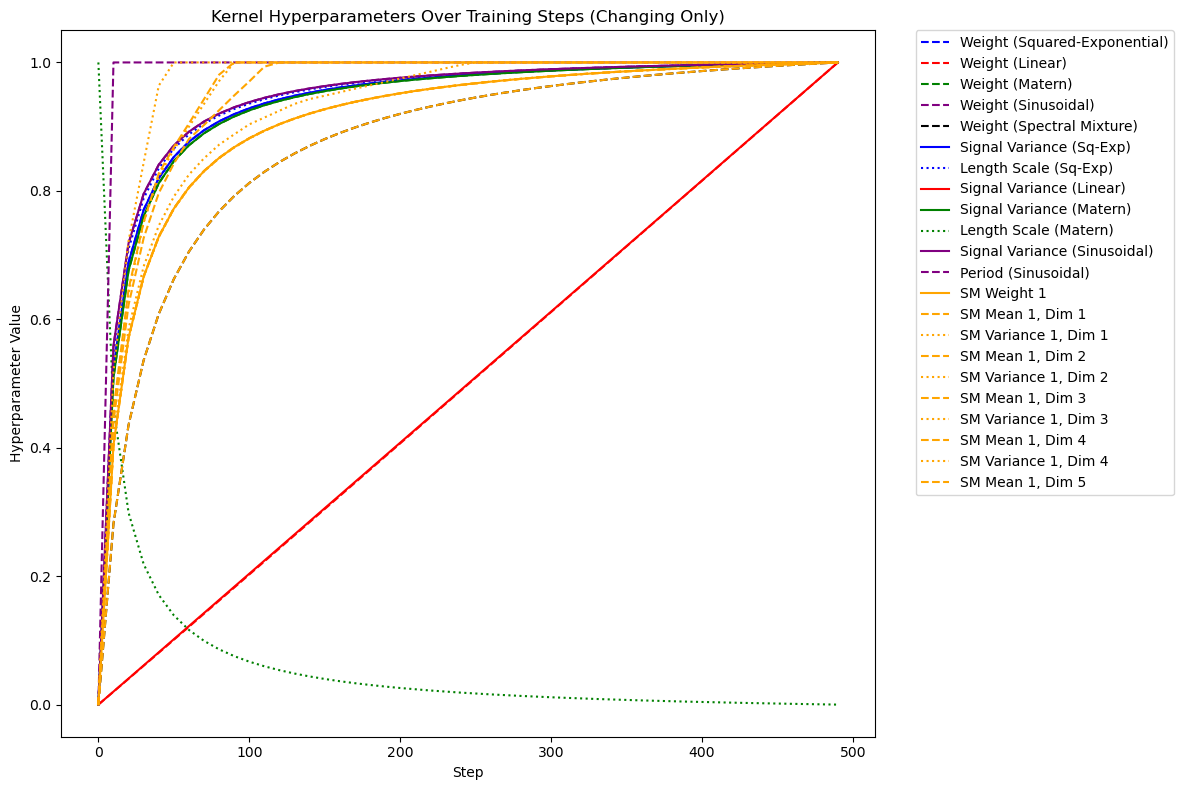

In [ ]:
plot_kernel_hyperparameters(history, dims=5)